In [1]:
# 示例代码运行环境
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 2.7.6
IPython 5.2.2

tensorflow 1.0.0
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.contrib.legacy_seq2seq import basic_rnn_seq2seq, embedding_rnn_seq2seq, sequence_loss
from tensorflow.python.ops import variable_scope
import jieba
from jieba import posseg as pseg
from collections import defaultdict, Counter
import random
import time
import re

In [3]:
import nltk

In [4]:
FILE_TRAIN_EN = 'TED_en_train.txt'
FILE_TRAIN_ZH = 'TED_zh_train.txt'
FILE_TEST_EN = 'TED_en_test.txt'
FILE_TEST_ZH = 'TED_zh_test.txt'

In [5]:
#读取英文语料，分词
def load_en_file(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        words_all = []
        lines_dict = []
        for line in lines:
            try:
                words = nltk.tokenize.word_tokenize(line.strip())   
            except:
                #处理训练语料中的非assii字符，替换后再分词
                #print line
                new_line = re.sub(r'\xa1\xaf', '\'', line.strip())
                #print new_line
                words = nltk.tokenize.word_tokenize(new_line.strip())            
                
            words_all += words
            lines_dict.append(words)
        return words_all, lines_dict
            

In [6]:
t0 = time.time()
words_test_en, lines_test_en = load_en_file(FILE_TEST_EN)
t1 = time.time()
print(t1-t0)

2.03207087517


In [7]:
t0 = time.time()
words_train_en, lines_train_en = load_en_file(FILE_TRAIN_EN)
t1 = time.time()
print(t1-t0)

36.3412718773


In [8]:
print(len(words_train_en))
print(len(lines_train_en))

total_en_words = Counter(words_train_en)
print(len(total_en_words))

print lines_train_en[81988]

print words_train_en[:10]
print lines_train_en[:3]

2694428
300000
54059
['My', 'TED', 'wish', '.', 'There', "'s", 'a', 'vital', 'story', 'that', 'needs', 'to', 'be', 'told']
['It', 'can', 'be', 'a', 'very', 'complicated', 'thing', ',', 'the', 'ocean']
[['It', 'can', 'be', 'a', 'very', 'complicated', 'thing', ',', 'the', 'ocean', '.'], ['And', 'it', 'can', 'be', 'a', 'very', 'complicated', 'thing', ',', 'what', 'human', 'health', 'is', '.'], ['And', 'bringing', 'those', 'two', 'together', 'might', 'seem', 'a', 'very', 'daunting', 'task', ',']]


In [9]:
print(len(words_test_en))
print(len(lines_test_en))

print words_test_en[:10]
print lines_test_en[:2]

130471
14872
['We', 'could', 'use', 'sales', ',', 'anything', 'you', 'like', '.', 'There']
[['We', 'could', 'use', 'sales', ',', 'anything', 'you', 'like', '.'], ['There', 'it', 'is', ':', 'after', 'some', 'little', 'fluctuations', 'at', 'the', 'beginning', ',']]


In [10]:
def load_zh_file(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        words_all = []
        lines_dict = []        
        for line in lines:
            words = [w for (w,x) in pseg.cut(line.strip().decode('utf-8'))]
            words_all += words
            lines_dict.append(words)
        return words_all, lines_dict

In [12]:
t0 = time.time()
words_test_zh, lines_test_zh = load_zh_file(FILE_TEST_ZH)
t1 = time.time()
print(t1-t0)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.350 seconds.
Prefix dict has been built succesfully.


10.6360740662


In [13]:
print(len(words_test_zh))
print(len(lines_test_zh))

for l in lines_test_zh[:2]:
    text = ' '.join(l)
    print(text)

115659
14872
我们 还 可以 用 销售量   什么 都行
看   当 公司 进行 革新


In [14]:
t0 = time.time()
words_train_zh, lines_train_zh = load_zh_file(FILE_TRAIN_ZH)
t1 = time.time()
print(t1-t0)

202.379176855


In [15]:
print(len(words_train_zh))
print(len(lines_train_zh))

total_zh_words = Counter(words_train_zh)
print(len(total_zh_words))

for l in lines_train_zh[:2]:
    text = ' '.join(l)
    print(text)


2450264
300000
67317
海洋 是 一个 非常复杂 的 事物 。
人类 的 健康 也 是 一件 非常复杂 的 事情 。


In [23]:
UNK_WORD = u'<UNK>'
PADDING_WORD = u'<PAD>'
START_WORD = u'<GO>'
END_WORD = u'<EOS>'

In [24]:
def build_dataset(segs, sentences, vocab_size, is_decoder=False):    
    word_cnt = Counter(segs).most_common(vocab_size - 4)    
    word_dict = dict()  
    word_dict[PADDING_WORD] = 0 
    for word, _ in word_cnt:
        word_dict[word] = len(word_dict)    
    word_dict[UNK_WORD] = len(word_dict)
    word_dict[START_WORD] = len(word_dict)
    word_dict[END_WORD] = len(word_dict)
    sentence_data = []
    unk_count = 0
    for sentence in sentences:
        cur_sentence = []
        if is_decoder:
            cur_sentence.append(word_dict[START_WORD])
        for word in sentence:
            if word in word_dict:
                index = word_dict[word]
            else:
                index = word_dict[UNK_WORD]  # UNK_WORD
                unk_count += 1
            cur_sentence.append(index)
        if is_decoder:
            cur_sentence.append(word_dict[END_WORD])
        sentence_data.append(cur_sentence)    
    reverse_dict = dict(zip(word_dict.values(), word_dict.keys())) 
    return sentence_data, word_cnt, word_dict, reverse_dict

In [25]:
def build_test_dataset(sentences, word_dict, id_dict, is_decoder=False):
    sentence_data = []
    for sentence in sentences:
        cur_sentence = []
        for word in sentence:
            if word in word_dict:
                index = word_dict[word]
            else:
                index = word_dict[UNK_WORD]  # UNK_WORD
            cur_sentence.append(index)
        if is_decoder:
            cur_sentence = word_dict[START_WORD] + cur_sentence + word_dict[END_WORD]
        sentence_data.append(cur_sentence)    
    reverse_dict = dict(zip(word_dict.values(), word_dict.keys())) 
    return sentence_data

In [26]:
EN_VOCAB_SIZE = 10000
ZH_VOCAB_SIZE = 10000

In [27]:
t0 = time.time()
train_en_sentences, train_en_word_count, train_en_dict, train_en_reverse_dict = build_dataset(words_train_en, lines_train_en, EN_VOCAB_SIZE)
t1 = time.time()
print(t1-t0)

1.74033594131


In [28]:
print(len(train_en_sentences))
print(len(train_en_word_count))
print(len(train_en_dict))
print(len(train_en_reverse_dict))

print(train_en_sentences[:3])

for (w,v) in train_en_word_count[:5]:
    print(w,v)
for (w,v) in train_en_word_count[-5:]:
    print(w,v)  


300000
9996
10000
10000
[[40, 32, 33, 6, 51, 942, 114, 1, 3, 553, 2], [16, 13, 32, 33, 6, 51, 942, 114, 1, 30, 182, 425, 11, 2], [16, 1454, 124, 119, 220, 213, 754, 6, 51, 9165, 1414, 1]]
(',', 156395)
('.', 137284)
('the', 104573)
('to', 64287)
('of', 60913)
('learner', 10)
('Fall', 10)
('criticize', 10)
('rationality', 10)
('lifestyles', 10)


In [29]:
t0 = time.time()
train_zh_sentences, train_zh_word_count, train_zh_dict, train_zh_reverse_dict = build_dataset(
    words_train_zh, lines_train_zh, ZH_VOCAB_SIZE, is_decoder=True)
t1 = time.time()
print(t1-t0)

1.90747404099


In [30]:
train_zh_len = []
for s in train_zh_sentences:
    train_zh_len.append(len(s))

max_index = np.argmax(train_zh_len)
print(np.mean(train_zh_len))
print(max_index)
print(len(train_zh_sentences[max_index]))
print(train_zh_sentences[max_index])
text = '';
for i in train_zh_sentences[max_index]:
    text += train_zh_reverse_dict[i] + ' '
print text

10.1675466667
104514
56
[9998, 7450, 12, 9997, 65, 12, 9997, 12, 9997, 38, 9997, 9997, 9997, 37, 65, 12, 9997, 12, 9997, 38, 9997, 626, 15, 953, 2626, 5176, 37, 38, 10, 229, 22, 20, 1973, 142, 2957, 1963, 760, 9997, 1, 626, 100, 1155, 9997, 37, 2, 9997, 984, 220, 30, 1806, 14, 7, 292, 341, 60, 9999]
<GO> Al   <UNK> ,   <UNK>   <UNK> （ <UNK> <UNK> <UNK> ） ,   <UNK>   <UNK> （ <UNK> 能源 和 商业 委员会 主席 ） （ 这 两个 人 都 致力于 通过 国会 推动 一项 <UNK> 的 能源 与 气候 <UNK> ） ， <UNK> 家伙 完全 不 懂得 他们 在 讲 些 什么 <EOS> 


In [31]:
train_en_len = []
for s in train_en_sentences:
    train_en_len.append(len(s))

max_index = np.argmax(train_en_len)
print(np.mean(train_en_len))
print(max_index)
print(len(train_en_sentences[max_index]))
print(train_en_sentences[max_index])
text = '';
for i in train_en_sentences[max_index]:
    text += train_en_reverse_dict[i] + ' '
print text

8.98142666667
118160
30
[4940, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 1, 3677, 262]
Ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh , ooh ! 


In [32]:
print(len(train_zh_sentences))
print(len(train_zh_word_count))
print(len(train_zh_dict))
print(len(train_zh_reverse_dict))

print(train_zh_sentences[:3])

for (w,v) in train_zh_word_count[:5]:
    print w,v
for (w,v) in train_zh_word_count[-5:]:
    print w,v

300000
9996
10000
10000
[[9998, 515, 5, 11, 3671, 1, 409, 3, 9999], [9998, 154, 1, 438, 26, 5, 353, 3671, 1, 114, 3, 9999], [9998, 63, 1654, 2709, 201, 415, 5, 353, 6083, 1, 882, 3, 9999]]
的 166966
， 123108
。 86019
我 52326
是 48229
童子军 13
前排 13
偏向 13
有件事 13
夜 13


In [33]:
t0 = time.time()
test_en_sentences = build_test_dataset(lines_test_en, train_en_dict, train_en_reverse_dict)
t1 = time.time()
print(t1-t0)

print(len(test_en_sentences))
print(test_en_sentences[:5])

0.0541579723358
14872
[[53, 100, 164, 3225, 1, 314, 12, 42, 2], [138, 13, 11, 48, 194, 95, 115, 6594, 34, 3, 570, 1], [74, 682, 21, 9997, 1], [23, 636, 4326, 2], [16, 15, 81, 405, 34, 9997, 682]]


In [34]:
t0 = time.time()
test_zh_sentences = build_test_dataset(lines_test_zh, train_zh_dict, train_zh_reverse_dict)
t1 = time.time()
print(t1-t0)

print(len(test_zh_sentences))
print(test_zh_sentences[:5])

0.056036233902
14872
[[6, 92, 23, 74, 9997, 12, 60, 7539], [120, 12, 70, 243, 176, 3329], [131, 77, 287, 5909, 9997], [67, 9997, 2350], [6, 530, 8, 9997, 772]]


In [35]:
num_encoder_symbols = len(train_en_dict)
num_decoder_symbols = len(train_zh_dict)
embedding_size = 128

print(num_encoder_symbols)
print(num_decoder_symbols)

10000
10000


In [36]:
def pad_sentence(data, length, pad_index, end_index, is_encode=True):
    result_ = []
    data_len = len(data)
    if (data_len >= length):
        result_ = data[:length] #长句做截断处理
        if not is_encode:
            result_[length-1] = end_index
    else:
        pad_len = length - data_len
        padding = [pad_index] * pad_len
        if is_encode:
            result_ = padding + data
        else:
            result_ = data + padding
    
    return result_
        

In [37]:
def get_batch_data(offset, size, input_data, output_data, input_len, output_len):
    input_ = input_data[offset:offset + size]
    output_ = output_data[offset:offset + size]    
    
    for i in range(len(input_)):
        input_[i] = pad_sentence(input_[i], input_len, 0, EN_VOCAB_SIZE-1)
        output_[i] = pad_sentence(output_[i], output_len, 0, ZH_VOCAB_SIZE-1, False)
    return input_, output_   

In [68]:
#BasicRNNCell
tf.reset_default_graph()

RNN_CELL_TYPE = 'BasicRNNCell'
learning_rate = 0.1

encoder_length = 15
decoder_length = 20
embed_dim = 64

cell = tf.contrib.rnn.BasicRNNCell(embed_dim)
num_encoder_symbols = EN_VOCAB_SIZE
num_decoder_symbols = ZH_VOCAB_SIZE
embedding_size = embed_dim

encoder_len_placeholder = tf.placeholder(tf.int32)

encoder_placeholders = [tf.placeholder(tf.int32, shape=[None],
                                       name="encoder_%d" % i) for i in range(encoder_length)]
decoder_placeholders = [tf.placeholder(tf.int32, shape=[None],
                                       name="decoder_%d" % i) for i in range(decoder_length)]
target_placeholders = [tf.placeholder(tf.int32, shape=[None],
                                       name="target_%d" % i) for i in range(decoder_length)]
target_weights_placeholders = [tf.placeholder(tf.float32, shape=[None],
                                       name="decoder_weight_%d" % i) for i in range(decoder_length)]
outputs, states = embedding_rnn_seq2seq(
    encoder_placeholders, decoder_placeholders, cell,
    num_encoder_symbols, num_decoder_symbols,
    embedding_size, output_projection=None,
    feed_previous=False)

loss = sequence_loss(outputs, target_placeholders, target_weights_placeholders)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [87]:
#GRUCell
tf.reset_default_graph()

RNN_CELL_TYPE = 'GRUCell'
learning_rate = 1.0

encoder_length = 15
decoder_length = 20
embed_dim = 64

cell = tf.contrib.rnn.GRUCell(embed_dim)
num_encoder_symbols = EN_VOCAB_SIZE
num_decoder_symbols = ZH_VOCAB_SIZE
embedding_size = embed_dim

encoder_len_placeholder = tf.placeholder(tf.int32)

encoder_placeholders = [tf.placeholder(tf.int32, shape=[None],
                                       name="encoder_%d" % i) for i in range(encoder_length)]
decoder_placeholders = [tf.placeholder(tf.int32, shape=[None],
                                       name="decoder_%d" % i) for i in range(decoder_length)]
target_placeholders = [tf.placeholder(tf.int32, shape=[None],
                                       name="target_%d" % i) for i in range(decoder_length)]
target_weights_placeholders = [tf.placeholder(tf.float32, shape=[None],
                                       name="decoder_weight_%d" % i) for i in range(decoder_length)]
outputs, states = embedding_rnn_seq2seq(
    encoder_placeholders, decoder_placeholders, cell,
    num_encoder_symbols, num_decoder_symbols,
    embedding_size, output_projection=None,
    feed_previous=False)

loss = sequence_loss(outputs, target_placeholders, target_weights_placeholders)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [50]:
def left_shift(decoder_inputs, pad_idx):
    # for generating targets
    return [list(input_[1:]) + [pad_idx] for input_ in decoder_inputs]

In [51]:
def generate_feed_dict(batch_encoder_inputs, batch_decoder_inputs, pad_index):
    encoder_inputs_ = zip(*batch_encoder_inputs)  

    target_inputs_ = zip(*left_shift(batch_decoder_inputs, pad_index))
    decoder_inputs_ = zip(*batch_decoder_inputs)

    feed_dict = dict()
    # Prepare input data    
    for (i, placeholder) in enumerate(encoder_placeholders):
        # 这里用 placeholder 或者 placeholder.name 都可以
        feed_dict[placeholder.name] = np.asarray(encoder_inputs_[i], dtype=int)
        for i in range(len(decoder_placeholders)):
            feed_dict[decoder_placeholders[i].name] = np.asarray(decoder_inputs_[i], dtype=int)
            feed_dict[target_placeholders[i].name] = np.asarray(target_inputs_[i], dtype=int)        
            # 这里使用 weights 把 <PAD> 的损失屏蔽了
            feed_dict[target_weights_placeholders[i].name] = np.asarray([float(idx != pad_index) for idx in target_inputs_[i]],
                                                              dtype=float)
    return feed_dict

In [42]:
def print_translated_result(reverse_dict, output):
    text = ''
    for i in reverse_dict[output]:
        text += i
    return text

In [94]:
epoch_num = 100
batch_size = 10
sample_ratio = 1000 #为节约训练时间，只用 1/ Sample_ratio的样本数据训练

train_data_size = len(train_en_sentences)
iteration_num = train_data_size / batch_size / sample_ratio
#if train_data_size % batch_size > 0:
#    iteration_num += 1

display_step = iteration_num / 3 

print train_data_size
print iteration_num
print display_step


pad_index = 0

300000
30
10


In [95]:
saver = tf.train.Saver()
sess = tf.Session()

sess.run(tf.global_variables_initializer())

print("Start training, Cell type=%s, Learning rate=%f" % (RNN_CELL_TYPE, learning_rate))

costs = []
t0 = time.time()
for epoch in range(epoch_num):
    #print("Start epoch %d" % epoch)
        
    offset = 0
    #iteration_num = 1
    for i in range(iteration_num):            
        encoder_inputs, decoder_inputs = get_batch_data(
            offset, batch_size, 
            train_en_sentences, train_zh_sentences, 
            encoder_length, decoder_length)
        offset += batch_size

        feed_dict1 = generate_feed_dict(encoder_inputs, decoder_inputs, pad_index)

        sess.run(train_step, feed_dict1)
        
        #if i % display_step == 0:
        #    print("%d, %f" % (i, sess.run(loss, feed_dict1)))
    c = sess.run(loss, feed_dict1)
    costs.append(c)
    print("epoch %d, cost=%f" %(epoch, c))
            

t1 = time.time()
print("Training duration:%d" % (t1-t0))

saved_model = saver.save(sess, RNN_CELL_TYPE+'_model')
print("Modeled saved to: %s" % saved_model)


Start training, Cell type=GRUCell, Learning rate=1.000000
epoch 0, cost=6.116482
epoch 1, cost=5.538084
epoch 2, cost=5.447281
epoch 3, cost=5.296375
epoch 4, cost=5.137961
epoch 5, cost=4.723701
epoch 6, cost=4.531603
epoch 7, cost=4.775733
epoch 8, cost=4.334773
epoch 9, cost=4.029653
epoch 10, cost=3.850163
epoch 11, cost=3.705874
epoch 12, cost=3.582166
epoch 13, cost=3.459566
epoch 14, cost=3.343997
epoch 15, cost=3.210530
epoch 16, cost=3.086693
epoch 17, cost=2.964902
epoch 18, cost=2.849318
epoch 19, cost=2.733878
epoch 20, cost=2.649535
epoch 21, cost=2.671373
epoch 22, cost=2.435429
epoch 23, cost=2.372858
epoch 24, cost=2.226807
epoch 25, cost=2.154705
epoch 26, cost=2.043576
epoch 27, cost=1.926313
epoch 28, cost=1.800859
epoch 29, cost=1.727226
epoch 30, cost=1.628427
epoch 31, cost=1.712189
epoch 32, cost=1.462310
epoch 33, cost=1.365443
epoch 34, cost=1.280562
epoch 35, cost=1.234641
epoch 36, cost=1.150338
epoch 37, cost=1.076319
epoch 38, cost=1.009145
epoch 39, cost=1

100


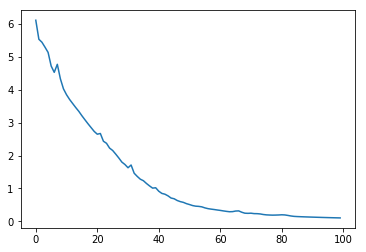

In [96]:
print(len(costs))
plt.plot(costs)

In [97]:
def decode_data(session, offset, size, encode_input, decode_input):
    # Decoding
    with variable_scope.variable_scope(variable_scope.get_variable_scope(), reuse=True):
        outputs, states = embedding_rnn_seq2seq(
             encoder_placeholders, decoder_placeholders, cell,
            num_encoder_symbols, num_decoder_symbols,
            embedding_size, output_projection=None,
            feed_previous=True)
         
        test_encoder_inputs, test_decoder_inputs = get_batch_data(
                offset, size, 
                encode_input, decode_input, 
                encoder_length, decoder_length)

        feed_dict_test = generate_feed_dict(test_encoder_inputs, test_decoder_inputs, pad_index)        
      
        result = []
        for o in outputs:
            # 注意这里也需要提供 feed_dict
            m = np.argmax(o.eval(feed_dict_test, session=sess), axis=1)
            result.append(m[0])

        return result            


In [98]:
def index_to_words(data, dictionary):
    text = ' '.join([dictionary[i] for i in data])
    return text

In [99]:
def decode_lines(line_count, offset, encode_input, decode_input, encode_dict, decode_dict):
    for i in range(line_count):
        index = offset+i
        output = decode_data(sess, index, 1, encode_input, decode_input)
        print("Line#: %d" % (index+1))
        print("Input: %s" % index_to_words(encode_input[index], encode_dict))
        print("Result: %s" % index_to_words(output, decode_dict))
        print("Expect: %s" % index_to_words(decode_input[index], decode_dict)) 
        print("----------------------------------")

In [100]:
#训练数据集翻译测试
decode_lines(3, 100, train_en_sentences, train_zh_sentences, train_en_reverse_dict, train_zh_reverse_dict)


Line#: 101
Input: and we had those instead .
Result: 来 替代 它们 。 <EOS> 。 <EOS> 。 <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> 。 <EOS> <EOS> <EOS> 。
Expect: <GO> 来 替代 它们 。 <EOS>
----------------------------------
Line#: 102
Input: Well , some of us would be eating those <UNK>
Result: 嗯 ， 我们 之中 的 一些 人会 把 巧克力 吃 了 <EOS> 巧克力 的 巧克力 <EOS> 吗 ， <EOS> 吗
Expect: <GO> 嗯 ， 我们 之中 的 一些 人会 把 巧克力 吃 了 <EOS>
----------------------------------
Line#: 103
Input: instead of passing them around ,
Result: 而 不 给 别人 。 <EOS> 顶部 。 <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> 。 <EOS> <EOS> <EOS> <EOS>
Expect: <GO> 而 不 给 别人 。 <EOS>
----------------------------------


In [103]:
#测试数据集翻译测试
decode_lines(3, 20, test_en_sentences, test_zh_sentences, train_en_reverse_dict, train_zh_reverse_dict)

Line#: 21
Input: If it has this <UNK> scaling ,
Result: 最 <UNK> 这里 ， <EOS> ， <EOS> 的 <EOS> ， <EOS> 。 <EOS> 。 <EOS> <EOS> <EOS> 。 <EOS> <EOS>
Expect: 如果 其 规模 的 增长 呈 次 线性
----------------------------------
Line#: 22
Input: the theory says
Result: <UNK> 的 <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Expect: 依照 原理
----------------------------------
Line#: 23
Input: we should have <UNK> growth .
Result: 巧克力 巧克力 巧克力 的 <UNK> 巧克力 。 <EOS> 体内 <EOS> 。 <EOS> <EOS> <EOS> 。 <EOS> <EOS> <EOS> 。 <EOS>
Expect: 我们 应该 会 得到 一个 S 型 的 增长
----------------------------------
